In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import sys
sys.path.append("../")

import seaborn as sns
sns.set_style("white")

# sklearn imports
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# svm
from sklearn.svm import SVR

# gaussian process reg
import sklearn.gaussian_process as gp
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel

# scipy imports
from scipy.stats import zscore

import src.linear_regression as lr


In [2]:
df_wmt = pd.read_pickle("../data/wmt21_processed_data.pkl")

In [3]:
df_wmt.drop(df_wmt[df_wmt["model"].apply(lambda x : "ref-" in x)].index, inplace=True) 

In [4]:
max_bleu_scores = df_wmt.groupby(["dataset", "langpair"])["bleu"].max()
df_wmt_joined = df_wmt.join(max_bleu_scores, on=["dataset", "langpair"], rsuffix="_max")

In [5]:
df_wmt[df_wmt_joined["bleu"] == df_wmt_joined["bleu_max"]]

,dataset,langpair,model,genetic,geographic,syntactic,inventory,phonological,featural,mover_score,bleu,rouge2,source_ttr,target_ttr,data_size,ttr_distance
8,newstest2021,ja-en,WeChat-AI,1.0000,0.5,0.66,0.5472,0.5032,0.6,0.515093,25.932918,0.363170,0.177418,0.193654,1005,0.007029
10,newstest2021,en-ha,NiuTrans,1.0000,0.2,0.45,0.5337,0.4270,0.5,0.569580,19.775145,0.271405,0.214678,0.217593,1000,0.000180
13,newstest2021,ru-en,Online-G,0.9000,0.2,0.49,0.5594,0.2804,0.5,0.698110,39.703466,0.527101,0.373318,0.217226,1000,0.516340
42,newstest2021,en-is,NiuTrans,0.7000,0.1,0.47,0.4694,0.5687,0.5,0.714493,28.839876,0.394483,0.214678,0.344759,1000,0.142364
63,florestest2021,xh-zu,TRANSSION,0.0769,0.0,0.55,0.3550,0.5228,0.5,0.549491,13.636079,0.142920,0.763626,0.737340,503,0.001271
94,newstest2021,de-en,Facebook-AI,0.4286,0.1,0.42,0.4364,0.3277,0.4,0.666855,39.760109,0.540546,0.295504,0.212679,1000,0.151658
97,challengeset,en-de,system1,0.4286,0.1,0.42,0.4364,0.3277,0.4,0.681381,38.094441,0.456811,0.211445,0.219234,177,0.001262
145,newstest2021,en-ja,NiuTrans,1.0000,0.5,0.66,0.5472,0.5032,0.6,0.733872,12.668144,0.094403,0.214678,0.143099,1000,0.250201
150,newstest2021,fr-de,Online-B,0.8571,0.0,0.46,0.3886,0.2617,0.4,0.700721,42.055920,0.518218,0.206524,0.236358,1026,0.015933
160,florestest2021,hi-bn,Online-B,0.6250,0.1,0.53,0.3481,0.3613,0.4,0.670168,15.784419,0.015553,0.230598,0.372326,509,0.144898


In [6]:
train, test = train_test_split(df_wmt, test_size=0.15) 

# 1. Linear regression with just URIEL features

- train simple linear regression model with URIEL features
- plot bootstrapped sample coefficients (vertical line = coefficient of linear regression with all data)
- get feature importances

In [7]:
pipeline = lr.build_simple_regression_pipeline()
pipelines = lr.bootstrap_train(train, pipeline, lr.metrics, lr.uriel_features)
pipeline_population = lr.train_regression(train, pipeline, lr.metrics, lr.uriel_features)
coefficients = lr.gather_coefficients(pipelines, lr.metrics, lr.uriel_features)


### 1.1 BLEU score bootstrapped coefficients

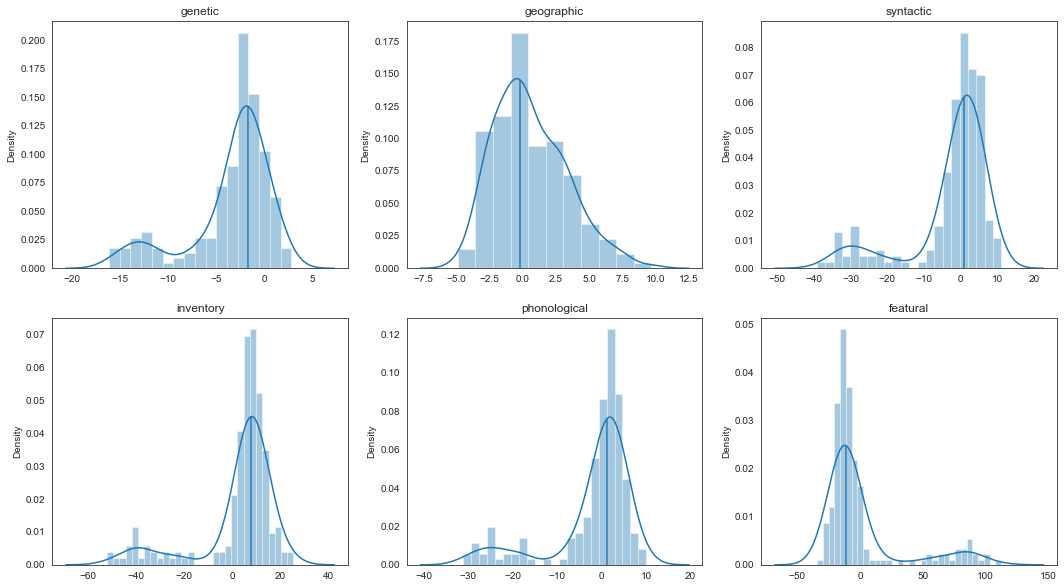

In [8]:
population_val = pipeline_population["regression"].coef_[0]

fig, axs = plt.subplots(2,3,figsize=(18, 10))
i=0

for feat, ax in zip(lr.uriel_features, axs.ravel()):
    sns.distplot(coefficients["bleu"][feat], ax=ax) 
    kdeline = ax.lines[0]
    xs = kdeline.get_xdata()
    ys = kdeline.get_ydata()
    height = np.interp(population_val[i], xs, ys)
    ax.vlines(population_val[i],0,height)
    ax.set_title(feat)
    i+=1
    
plt.show()

### 1.2 Mover score bootstrapped coefficients

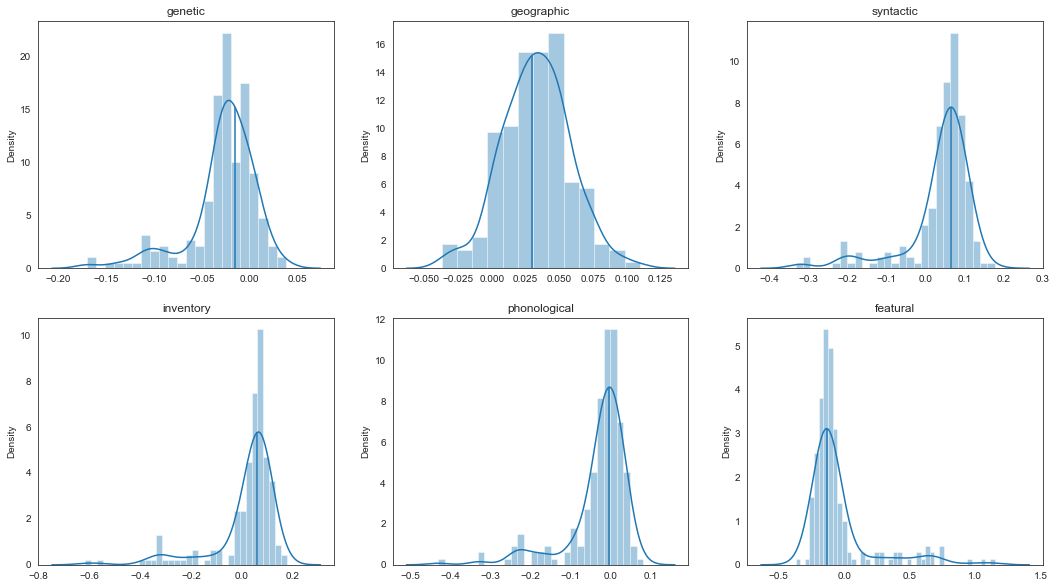

In [9]:
population_val = pipeline_population["regression"].coef_[2]

fig, axs = plt.subplots(2,3,figsize=(18, 10))
i=0

for feat, ax in zip(lr.uriel_features, axs.ravel()):
    sns.distplot(coefficients["mover_score"][feat], ax=ax) 
    kdeline = ax.lines[0]
    xs = kdeline.get_xdata()
    ys = kdeline.get_ydata()
    height = np.interp(population_val[i], xs, ys)
    ax.vlines(population_val[i],0,height)
    ax.set_title(feat)
    i+=1
    
plt.show()

### 1.3 ROUGE2 score bootstrapped coefficients

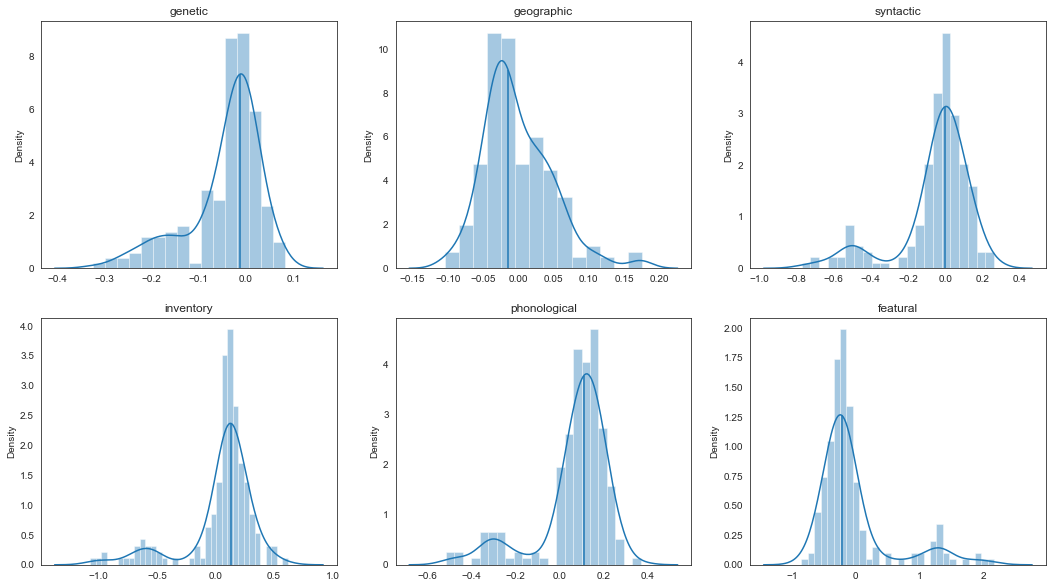

In [10]:
population_val = pipeline_population["regression"].coef_[1]

fig, axs = plt.subplots(2,3,figsize=(18, 10))
i=0

for feat, ax in zip(lr.uriel_features, axs.ravel()):
    sns.distplot(coefficients["rouge2"][feat], ax=ax) 
    kdeline = ax.lines[0]
    xs = kdeline.get_xdata()
    ys = kdeline.get_ydata()
    height = np.interp(population_val[i], xs, ys)
    ax.vlines(population_val[i],0,height)
    ax.set_title(feat)
    i+=1
    
plt.show()

### 1.4 MSE and R2 score

In [11]:
lr.print_results(pipeline_population, lr.uriel_features, test)

mse error: 26.290129851210637, r2 score: 0.0543371455533909


# 2. Linear regression with all features

- train simple linear regression model with URIEL features
- plot bootstrapped sample coefficients (vertical line = coefficient of linear regression with all data)
- get feature importances

In [12]:
lr.all_features

['genetic',
 'geographic',
 'syntactic',
 'inventory',
 'phonological',
 'featural',
 'source_ttr',
 'target_ttr',
 'data_size',
 'ttr_distance']

In [13]:
features = ['genetic',
 'geographic',
 'syntactic',
 'inventory',
 'phonological',
 'featural',
 'source_ttr',
 'target_ttr',
 'ttr_distance'
]

In [14]:


pipeline = lr.build_simple_regression_pipeline()
pipelines = lr.bootstrap_train(train, pipeline, lr.metrics, features)
pipeline_population = lr.train_regression(train, pipeline, lr.metrics, features)
coefficients = lr.gather_coefficients(pipelines, lr.metrics, features)


### 2.1 BLEU score bootstrapped coefficients

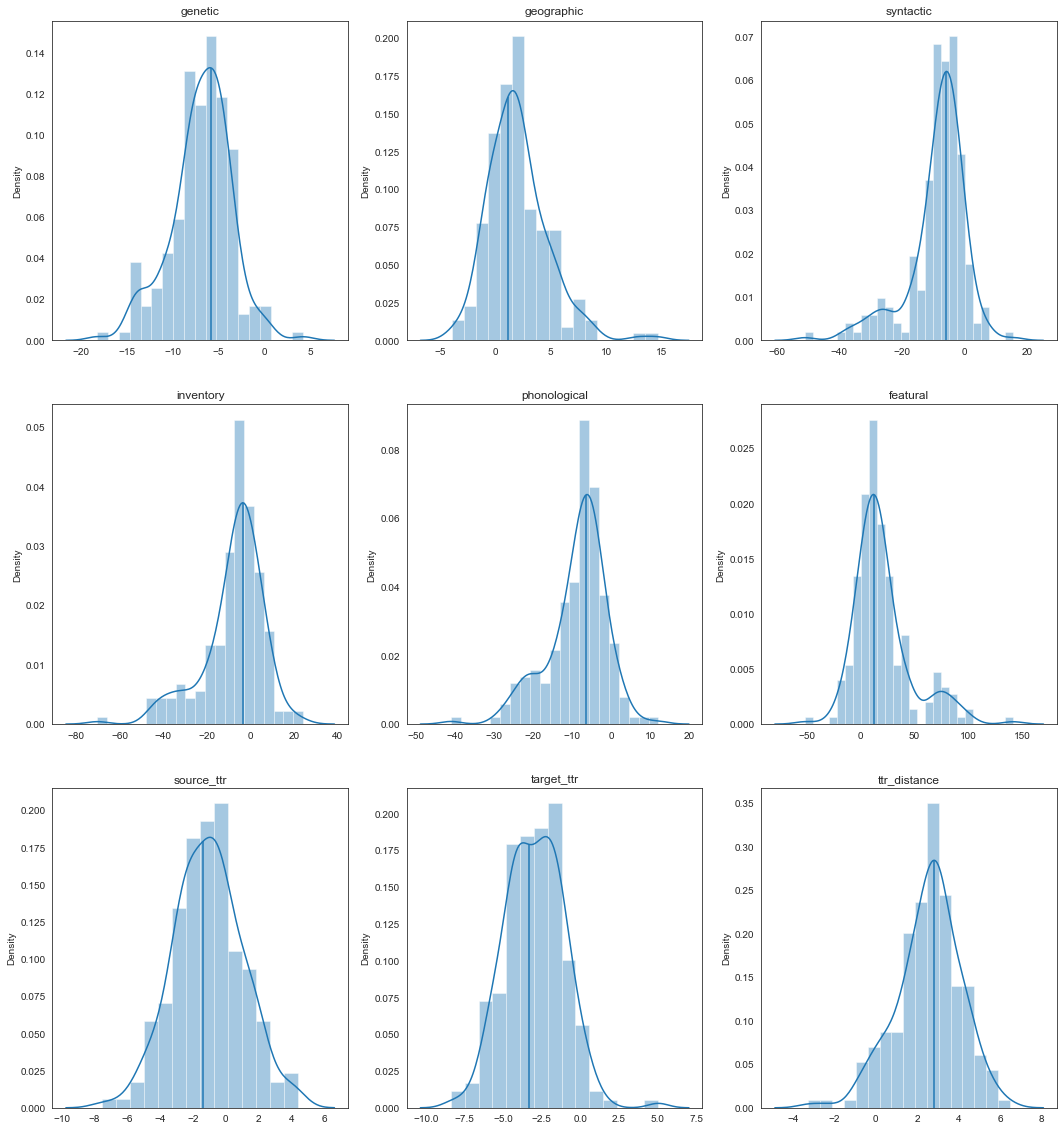

In [15]:
population_val = pipeline_population["regression"].coef_[0]
fig, axs = plt.subplots(3,3,figsize=(18, 20))
i=0

for feat, ax in zip(features, axs.ravel()):
    sns.distplot(coefficients["bleu"][feat], ax=ax) 
    kdeline = ax.lines[0]
    xs = kdeline.get_xdata()
    ys = kdeline.get_ydata()
    height = np.interp(population_val[i], xs, ys)
    ax.vlines(population_val[i],0,height)
    ax.set_title(feat)
    i+=1
    
plt.show()

### 2.2 Mover score bootstrapped coefficients

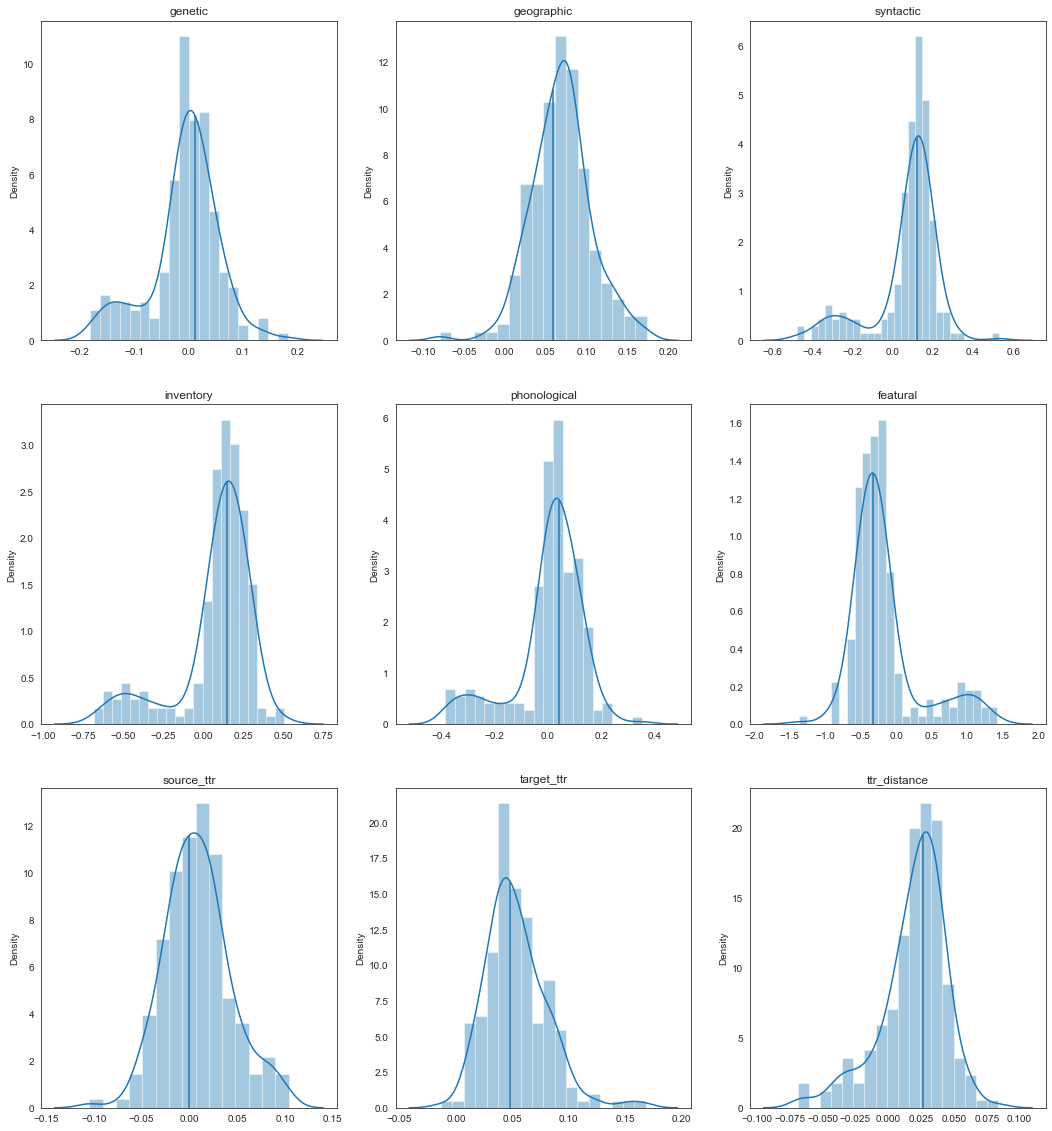

In [16]:
population_val = pipeline_population["regression"].coef_[2]
fig, axs = plt.subplots(3,3,figsize=(18, 20))
i=0

for feat, ax in zip(features, axs.ravel()):
    sns.distplot(coefficients["mover_score"][feat], ax=ax) 
    kdeline = ax.lines[0]
    xs = kdeline.get_xdata()
    ys = kdeline.get_ydata()
    height = np.interp(population_val[i], xs, ys)
    ax.vlines(population_val[i],0,height)
    ax.set_title(feat)
    i+=1
    
plt.show()

### 2.3 ROUGE2 score bootstrapped coefficients

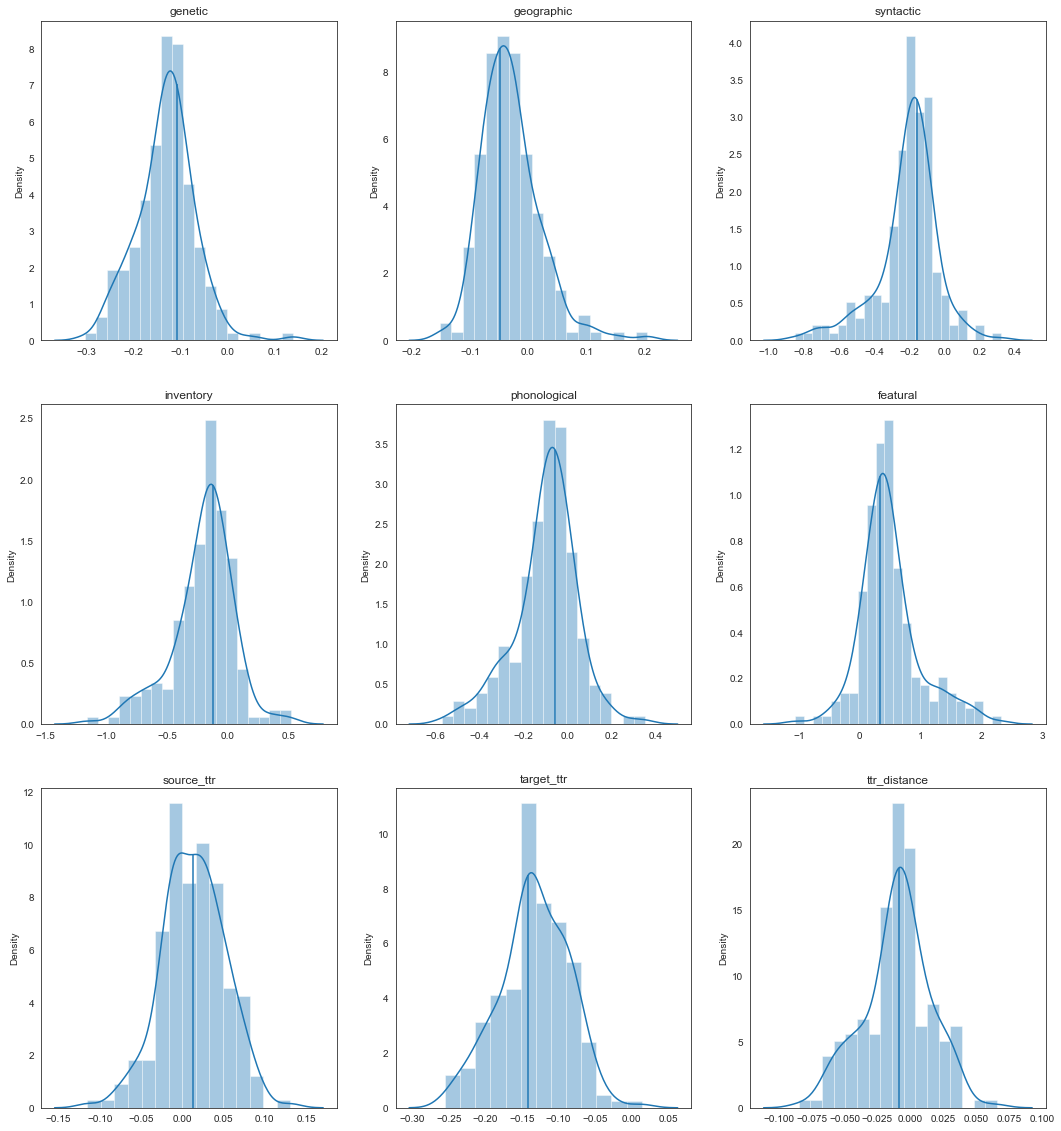

In [17]:
population_val = pipeline_population["regression"].coef_[1]
fig, axs = plt.subplots(3,3,figsize=(18, 20))
i=0

for feat, ax in zip(features, axs.ravel()):
    sns.distplot(coefficients["rouge2"][feat], ax=ax) 
    kdeline = ax.lines[0]
    xs = kdeline.get_xdata()
    ys = kdeline.get_ydata()
    height = np.interp(population_val[i], xs, ys)
    ax.vlines(population_val[i],0,height)
    ax.set_title(feat)
    i+=1
    
plt.show()

In [18]:
lr.print_results(pipeline_population, features, test)

mse error: 31.788678084383733, r2 score: -0.23661029815031553


MSE/R2 scores are really bad for simple regression. Tried polynomial regression and basis expanded regression, and the performances were similarly bad. I think there might be some issues with preprocessing. Few problems I can think of:
- type token ratio calculation doesn't take into account pretrained models. I just calculated   
-
-

### Polynomial Regression

In [19]:
degrees = [1,2,3,4,5,6]


for degree in degrees:
    
    pipeline=lr.build_polynomial_regression_pipeline(degree)
    lr.train_regression(train, pipeline, lr.metrics, features)
    lr.print_results(pipeline, features, test)
    


mse error: 31.788678084383772, r2 score: -0.23661029815031656
mse error: 2.4711740517637807e+25, r2 score: -4.59303852322876e+23
mse error: 5.522727774770299e+22, r2 score: -2.0526200540905973e+21
mse error: 36.71173224487612, r2 score: -0.16650420881002326
mse error: 3.3061464193388846e+18, r2 score: -8.021072366401496e+16
mse error: 35.56520654572194, r2 score: -0.34284705774168117


In [261]:
model = SVR(C=2.4, epsilon=2.6, kernel='sigmoid')
#model = SVR(C=2, epsilon=12, kernel='rbf')



In [262]:
model.fit(train[features], train["bleu"])

SVR(C=2.4, epsilon=2.6, kernel='sigmoid')

In [263]:
model.score(test[features], test["bleu"])

0.11322779616934986

In [264]:
test_pred = model.predict(test[features])

In [265]:

mean_squared_error(test_pred, test["bleu"])

74.91310670187502

In [267]:
y_pred = model.predict(test[features])

In [290]:
model = SVR(C=1, epsilon=1, kernel='sigmoid')
model.fit(train[features], train["rouge2"])
model.score(test[features], test["rouge2"])

-0.2940898236724132

In [291]:
test_pred = model.predict(test[features])
mean_squared_error(test_pred, test["rouge2"])

0.027778716009973448

In [25]:
kernel = gp.kernels.ConstantKernel(1, (1e-1,1e3))*gp.kernels.RBF(10, (1e-3,1e3))
kernel = DotProduct() + WhiteKernel()

In [26]:
model = gp.GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, alpha=0.1, normalize_y=True)

In [27]:
model.fit(train[lr.uriel_features], train["bleu"])
params = model.kernel_.get_params()

In [28]:
y_pred, std = model.predict(test[lr.uriel_features], return_std=True)


In [29]:
mean_squared_error(y_pred, test["bleu"])

79.36346887020305

In [30]:
r2_score(y_pred, test["bleu"])

-213.2481236276017